## Linear Regression

Linear regression is one of the oldest supervised learning methods. It relates a number of input variables to an output variable, where the error is measured in terms of square error.

Here we follow the [MLLib Tutorial on Regression](http://spark.apache.org/docs/latest/mllib-linear-methods.html#regression)

In [2]:
%pylab inline
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [3]:
from pyspark.mllib.regression import LabeledPoint, LinearRegressionWithSGD, LinearRegressionModel, RidgeRegressionWithSGD
import pyspark.mllib.regression as reg

#### LinearRegressionWithSGD
Train a linear regression model with no regularization using Stochastic Gradient Descent.
[API Documentation](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LinearRegressionWithSGD)

It takes as input an RDD of **LabeledPoint**s. The goal is to find a linear model 
which best predicts the label variables as a linear combination of the input variables.

Denote by $\vec{x}_i$ the $i$th vector of input variables by $y_i$ the $i$th output variable, 
by $\vec{w}$ the vector of weights and by $a$ the point of interception. Then the least square solution 
is the setting of $\vec{w}$ and $a$ that minimizes the Mean Square Error:

$$ L(\vec{w},a) = \frac{1}{n}\sum_{i=1}^n (\vec{w} \cdot \vec{x}_i +a - y_i)^2 $$



#### Simple regression
We start with the simplest kind of linear regression, in which there is only one input variable. In other words $\vec{x}$ and $\vec{w}$ are scalars and the mean square error is 
$$ L(w,a) = \frac{1}{n}\sum_{i=1}^n (w x_i +a - y_i)^2 $$

In [4]:
from pyspark.mllib.regression import LabeledPoint
x=[0,1,2,3]
y=[0,1,2,4]
data = [ LabeledPoint(y[i],[x[i]]) for i in range(len(x))]
data

[LabeledPoint(0.0, [0.0]),
 LabeledPoint(1.0, [1.0]),
 LabeledPoint(2.0, [2.0]),
 LabeledPoint(4.0, [3.0])]

In [5]:
lrm = LinearRegressionWithSGD.train(sc.parallelize(data), iterations=100,
        intercept=True,initialWeights=np.array([1.0]))

In [6]:
slope=lrm.weights
intercept=lrm.intercept
lrm

(weights=[1.28844671071], intercept=-0.1753332466134248)

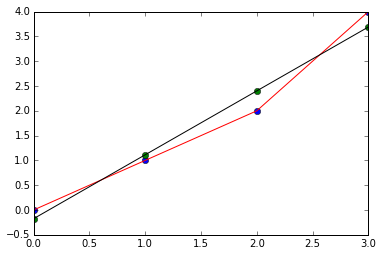

In [7]:
plot(x,y,'o')
plot(x,y,'r')
plot(x,intercept+slope*x,'og')
plot(x,intercept+slope*x,'k')

#### multiple Regression

We now extend to 

In [8]:
# Load and parse the data
def parsePoint(line):
    values = [float(x) for x in line.replace(',', ' ').split(' ')]
    return LabeledPoint(values[0], values[1:])

data2 = sc.textFile("../../../Data/regression/lpsa.data")
parsedData = data2.map(parsePoint)
print 'number of examples=',parsedData.count()
print 'number of input features=',len(parsedData.first().features)


number of examples= 67
number of input features= 8


In [9]:
# Build the model
model =LinearRegressionWithSGD.train(parsedData, iterations=1000, step=0.1,intercept=True,
                                     initialWeights=np.ones(8)*0.1)

print model
model
# Evaluate the model on training data
valuesAndPreds = parsedData.map(lambda p: (p.label, model.predict(p.features)))
#valuesAndPreds.take(10)

MSE = valuesAndPreds.map(lambda (v, p): (v - p)**2).reduce(lambda x, y: x + y) / valuesAndPreds.count()
print("Mean Squared Error = " + str(MSE))


#Save and load model
#model.save(sc, "myModelPath")
#sameModel = LinearRegressionModel.load(sc, "myModelPath")

(weights=[0.415795930868,0.266721498546,0.0100957989428,0.179765721365,0.272685132073,0.0136603829393,-0.00393003220158,0.170863489408], intercept=2.2483935484343074)
Mean Squared Error = 0.537072978047


In [10]:
## from pyspark.mllib.regression import LabeledPoint
x=[1,2,3,4];
y=[1,2,4,4];
data = sc.parallelize([LabeledPoint(y[i],[1,x[i],x[i]**2,x[i]**3]) for i in range(len(x))])
data.collect()

[LabeledPoint(1.0, [1.0,1.0,1.0,1.0]),
 LabeledPoint(2.0, [1.0,2.0,4.0,8.0]),
 LabeledPoint(4.0, [1.0,3.0,9.0,27.0]),
 LabeledPoint(4.0, [1.0,4.0,16.0,64.0])]

In [46]:
lrm = RidgeRegressionWithSGD.train(data, iterations=400, step=0.01,
        intercept=False,initialWeights=np.array([0,1,0,0]),regParam=0.001)

w0,w1,w2,w3=lrm.weights
intercept=lrm.intercept

print lrm
valuesAndPreds = data.map(lambda p: (p.label, lrm.predict(p.features)))
MSE=valuesAndPreds.map(lambda (v, p): (v - p)**2).reduce(lambda x, y: x + y) / valuesAndPreds.count()
print MSE

(weights=[0.0121671523301,1.03360961094,0.0619324678986,-0.0133369985531], intercept=0.0)
0.153455956091


In [12]:
xRange=arange(x[0],x[1],0.1)
yhat=[intercept+w1*xx+w2*xx*2 for xx in xRange]

In [13]:
from numpy import polyfit
weights=polyfit(np.array(x),np.array(y),3)
print weights
p = np.poly1d(weights)

[-0.5  3.5 -6.   4. ]


In [14]:
xx=arange(min(x),max(x),0.01)

In [15]:
for xp in x:
    print 'x=',xp, 'p(x)=',p(xp)

x= 1 p(x)= 1.0
x= 2 p(x)= 2.0
x= 3 p(x)= 4.0
x= 4 p(x)= 4.0


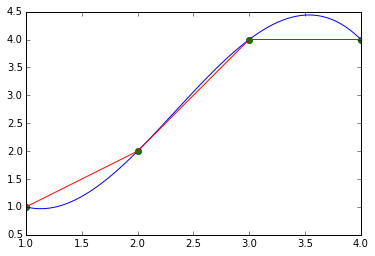

In [221]:
plot(xx,p(xx))
plot(x,y,'o')
plot(x,y,'r')

In [222]:
[weights[j]*xx[2]**j for j in range(len(weights))]

[-0.49999999999999972,
 3.5700000000000078,
 -6.2424000000000595,
 4.2448320000000708]

In [191]:
x,y

([1, 2, 3, 4], [1, 2, 4, 4])